In [3]:
import os
import re
import copy
import json
import numpy as np
import codecs
import pylcs
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2

# Utilities

In [5]:
def loadcache(name, path="."):
    out = np.load(f"{os.path.join(path, name)}.npy", allow_pickle=True)
    if isinstance(out, np.ndarray):
        return out
    else:
        return out.item()

In [6]:
def savecache(data, name, path="."):
    np.save(f"{os.path.join(path, name)}.npy", data)
    return 0

# Get Alignment

Load the alignment file

In [7]:
alignment = loadcache("./notebook_output/alignment")

# ------------------------------- MOVIE ---------------------------

# Get Scenes

In [8]:
SCENE_BREAK_PATH = "processed/dune/shotdetect/scene_detect_output.mat"

In [9]:
scene_breaks = sio.loadmat(SCENE_BREAK_PATH)['scene_breaks']
scene_breaks = scene_breaks - 1 # Convert from matlab indexing to python
scene_breaks = np.array(list(filter(lambda x: x[2], scene_breaks))) # Remove empty scenes
# scene_breaks

In [10]:
def shotsPerScene(scene):
    return np.arange(scene_breaks[scene][0], scene_breaks[scene][1]+1)

# Load Scene Break Times

In [11]:
scene_break_times = loadcache("scene_break_times")

# Get all Subtitles within range

In [12]:
from pysrt.srttime import SubRipTime

In [13]:
f = open("./processed/dune/dune_transcript.json", "r")
f = json.load(f)
TRANSCRIPT = f['transcript']

In [14]:
def get_subtitles(start, end):
    matched_subs = []
    for subtitle in TRANSCRIPT:
        
        # if subtitle['type']:
        #     continue

        time = subtitle['time']
        time_s = SubRipTime.from_string(subtitle['time'].split("-->")[0])
        time_ms = time_s.ordinal // 1000
        
#         time_ms = time_s.hour * 60 * 60 + time_s.minute * 60 + time_s.second

        if time_ms >= start and time_ms <= end:
            matched_subs.append(subtitle)
    return matched_subs

# ------------------------------- Book ----------------------------------

In [15]:
import nltk
import Stemmer
import math
from collections import Counter
from scripts.utils import *
from nltk.tokenize import word_tokenize, sent_tokenize
from scripts.lcs import *
from scripts.bookQuoteExtractor import Book, BookChunked, chapterText

In [16]:
chapters = sorted(os.listdir("./processed/dune/chapters"), key=lambda x: int(x.split('-')[0]))

In [17]:
book = BookChunked(chapters, "./processed/dune/chapters")

ch:  ./processed/dune/chapters
cp:  ['01-chap1', '02-chap2', '03-chap3', '04-chap4', '05-chap5', '06-chap6', '07-chap7', '08-chap8', '09-chap9', '10-chap10', '11-chap11', '12-chap12', '13-chap13', '14-chap14', '15-chap15', '16-chap16', '17-chap17', '18-chap18', '19-chap19', '20-chap20', '21-chap21', '22-chap22', '23-chap23', '24-chap24', '25-chap25', '26-chap26', '27-chap27', '28-chap28', '29-chap29', '30-chap30', '31-chap31', '32-chap32', '33-chap33']


In [18]:
words = word_tokenize(book.getAllText().lower())

stemmer = Stemmer.Stemmer('english')
stemmer.maxCacheSize = 10000

words = stemmer.stemWords(words)
wordCount = Counter(words)

In [19]:
idf = {word: 1/wordCount[word] for word in wordCount.keys()}

# Load CLIP and convert alignment to chunk-scene format

In [20]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image

In [21]:
#Load CLIP model
model = SentenceTransformer('clip-ViT-B-32')

2023-04-20 02:14:16.979990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 02:14:17.981475: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2023-04-20 02:14:17.981567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2023-04-20 02:14:17.981574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Compute image features for every shot in the movie

In [22]:
SHOT_DIR = "duneVSD/data/bbt_s01e01_excerpt"
shot_imgs = sorted(os.listdir(SHOT_DIR))

In [23]:
from tqdm import tqdm

feats = []
for i in tqdm(range(len(shot_imgs))):
    img = Image.open(os.path.join(SHOT_DIR, shot_imgs[i]))
    feat = model.encode(img)
    feats.append([feat])
feats = np.array(feats)


100%|██████████| 4568/4568 [02:21<00:00, 32.36it/s]


In [24]:
from copy import copy
f2 = copy(feats)
f2.squeeze(1).shape

(4568, 512)

In [25]:
np.savetxt("processed/dune/feats.csv", feats.squeeze(1), delimiter=",")     # processed/hp/img_features/feats.csv -> processed/dune/feats.csv

In [26]:
# # Load pre-computed shot features
shot_features = np.asarray(pd.read_csv(os.path.join("./processed/dune/", "feats.csv"), header=None), dtype=np.float32)

Match chunk and scene using Text only

In [27]:
def text_process_dialogue(sent):
    sent = lower_text(sent)
    sent = remove_extra_whitespace(sent)
    sent = remove_punctuation(sent)
    sent = word_tokenize(sent)
    
    return sent

In [28]:
CONCRETE_WORDS = pd.read_csv("data/concrete_words.txt", sep="\t")
print(CONCRETE_WORDS.head())

CONCRETE_WORDS = CONCRETE_WORDS.set_index('Word').T.to_dict('list')

            Word  Bigram  Conc.M  Conc.SD  Unknown  Total  Percent_known  \
0    roadsweeper       0    4.85     0.37        1     27           0.96   
1    traindriver       0    4.54     0.71        3     29           0.90   
2           tush       0    4.45     1.01        3     25           0.88   
3      hairdress       0    3.93     1.28        0     29           1.00   
4  pharmaceutics       0    3.77     1.41        4     26           0.85   

   SUBTLEX Dom_Pos  
0        0       0  
1        0       0  
2       66       0  
3        1       0  
4        0       0  


In [29]:
def concrete_filter(para):
    sentences = sent_tokenize(para)
    sentence_scores = []
    
    for sentence in sentences:
        word_scores = []

        sentence_words_pos = nltk.pos_tag(sentence.split())
        sentence_words_tup = list(filter(lambda x: x[1] in ['NN', 'NNS'], sentence_words_pos))
        
        for (word, tag) in sentence_words_tup:
            if word in CONCRETE_WORDS.keys():
                word_scores.append(CONCRETE_WORDS[word][1])
            
#         sentence_words_tup = list(filter(lambda x: x[1] in ['NNP', 'NNPS'], sentence_words_pos))            
#         for (word, tag) in sentence_words_tup:
#             word_scores.append(5)

        if len(word_scores) == 0:
            word_scores = [0]

        sentence_scores.append(np.mean(word_scores))
        
    sorted_sentences = [i[1] for i in sorted(enumerate(sentences), key=lambda x:sentence_scores[x[0]], reverse=True)]
    
    sentence = sorted_sentences[0]
    sentence_words_pos = nltk.pos_tag(sentence.split())

    for (word, tag) in sentence_words_pos:
#         if tag == 'NNP' or tag == 'NNPS':
        if word in ['Harry', 'Potter', 'Potters', 'Dursley', 'Dursleys', 'Weasley', 'Weasleys']:
            sentence = sentence.replace(word, '')
        
    return sentence

In [30]:
def get_tfidf_score(text, normalize=False):
    
    text = concrete_filter(text)
    words = word_tokenize(text.lower())

#     sentence_words_pos = nltk.pos_tag(words)
#     sentence_words_tup = list(filter(lambda x: x[1] in ['NN', 'NNP', 'NNS', 'NNPS'], sentence_words_pos))
#     words = list(map(lambda x: x[0], sentence_words_tup))
    
    words = stemmer.stemWords(words)
    
    wordCount = Counter(words)  
        
    tf_idf = 0
    for word in wordCount.keys():
        try:
            tf_idf += wordCount[word] * idf[word]
        except:
            continue
    
#     print(tf_idf)

    if not normalize:
        return tf_idf
    else:
        return tf_idf / len(wordCount.keys())

In [31]:
def matchChunkScenes(chunk, scenes_for_chapter):
        
    has_match = False
    matched_scenes = set()

    chunkText = chunk.splitlines() # Convert chunk to paras
    sent_text = list(filter(lambda x: len(x) > 0, chunkText)) # Filter the empty paras        

    # Go through every paragraph until you find a matching line
    for i, line in enumerate(sent_text):
        if len(line) == 0: 
            continue

        sentence = sent_text[i]

        # For every para search for all quotes
        quotes = re.findall('(?:\"(.*?)\"[^A-Za-z])', sentence)           
        quotes = list(map(lambda x: x.lower().strip(), quotes))
        quotes = list(filter(lambda x: len(x.split(' ')) > 3, quotes))

        # For all quotes in paragraph
        for quote in quotes:

            # For all scenes aligned with this chapter
            for scene in scenes_for_chapter:

                # Get all subtitles in scenes
                startTime = scene_break_times[scene][-2]
                endTime = scene_break_times[scene][-1]
                scene_subtitles = get_subtitles(startTime, endTime)

                # Get shots in scene
                startShot = scene_break_times[scene][0]
                endShot = scene_break_times[scene][1]

                # For all subtitles in scenes
                for subtitle in scene_subtitles:
                    quote_proc = text_process_dialogue(quote)
                    subtitle_text = text_process_dialogue(subtitle['line'])

                    word = lcs(quote_proc, subtitle_text)

                    if len(word)/max(len(quote), len(subtitle_text)) > 0.1 and len(word) > 3:
                        has_match = True
                        matched_scenes.add(scene)
    
    return matched_scenes

Match scene and chunk using CLIP

In [43]:
import torch
from tqdm import tqdm

def matchChunkScenesCLIP(chunk, scenes_for_chapter):
    has_match = False

    # need one scene for ONE chunk - no multiple matches for all paras    
    matched_scene = None
    matched_scene_score = 0
    matched_shot_idxs = None
    matched_sentence = None
    
    chunkText = chunk.splitlines() # Convert chunk to paras
    para_text = list(filter(lambda x: len(x) > 0 and '"' not in x and len(x) >= 25, chunkText)) # Filter the empty paras    
    
    sent_text = sorted(para_text, key=lambda x: get_tfidf_score(x, normalize=True), reverse=True)
        
    # Go through every paragraph until you find a matching line
    for i, para in tqdm(enumerate(sent_text)):
                                    
        sentence = concrete_filter(para)
        
        sentence_words = sentence.split()
        
        if len(sentence_words) <= 3:
            continue
#         sentence_words_pos = nltk.pos_tag(sentence_words)
#         sentence_words_tup = list(filter(lambda x: x[1] in ['NN', 'NNP', 'NNS', 'NNPS', 'JJ'], sentence_words_pos))
#         sentence_words = list(map(lambda x: x[0], sentence_words_tup))
        sentence = " ".join(sentence_words)[:250]

        sent_features = model.encode(sentence)

        sent_scene_scores = []

        for scene in scenes_for_chapter:

            shot_scene_features = np.zeros_like(shot_features)
            shot_scene_features[shotsPerScene(scene)] = shot_features[shotsPerScene(scene)]

#             print(np.float64(sent_features))
            shot_scores = []
            for i in range(len(shot_scene_features)):
                score = util.cos_sim(shot_scene_features[i], sent_features)
                shot_scores.append(score)
                
            for not_idx in range(len(shot_scores)):
                if not_idx not in shotsPerScene(scene):
                    shot_scores[not_idx] = 0

            best = np.argsort(shot_scores)[::-1] 

            # [Best score, std of shot idxs score, top 5 scores]
            sent_scene_scores.append([shot_scores[best[0]], np.std(best[:5]), shot_scores])

        # handle intro chapters, give them 0 as the closest scene
        if len(sent_scene_scores) == 0:
            sent_scene_scores.append([torch.tensor([0.]), torch.tensor([1.]), np.zeros_like(shot_features)])
            scenes_for_chapter.append(0)

        sent_scene_scores = np.array(sent_scene_scores)
        
        # print(sent_scene_scores.shape, sent_scene_scores)

        best_scene_idx = np.argmax(sent_scene_scores[:, 0])

        best_scene = scenes_for_chapter[best_scene_idx]
        best_scene_dets = sent_scene_scores[best_scene_idx]

        max_score, std_score, best_shot_scores = best_scene_dets
        best_shot_idxs = np.argsort(best_shot_scores)[::-1]

        max_score = max_score.numpy()[0]
        
        if max_score < 0.3:
            continue
        else:
            if max_score > matched_scene_score:
                matched_scene_score = max_score
                matched_scene = best_scene
                matched_shot_idxs = best_shot_idxs
                matched_sentence = sentence
                
    if matched_shot_idxs is None:
        return []

    fig, ax = plt.subplots(ncols=5, figsize=(25, 10))
    for idx, j in enumerate(matched_shot_idxs[:5]):
        ax[idx].imshow(Image.open(os.path.join(SHOT_DIR, shot_imgs[j*2])))
        ax[idx].set_title(str(j))
    plt.show()

    print("-- Scene", matched_scene, "Max", matched_scene_score, "--")
    print(matched_sentence)

    return [matched_scene]

Chapter 1


0it [00:00, ?it/s]/tmp/ipykernel_10726/2761435860.py:61: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sent_scene_scores = np.array(sent_scene_scores)
/tmp/ipykernel_10726/2761435860.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sent_scene_scores = np.array(sent_scene_scores)
20it [00:05,  3.49it/s]
39it [00:11,  3.36it/s]


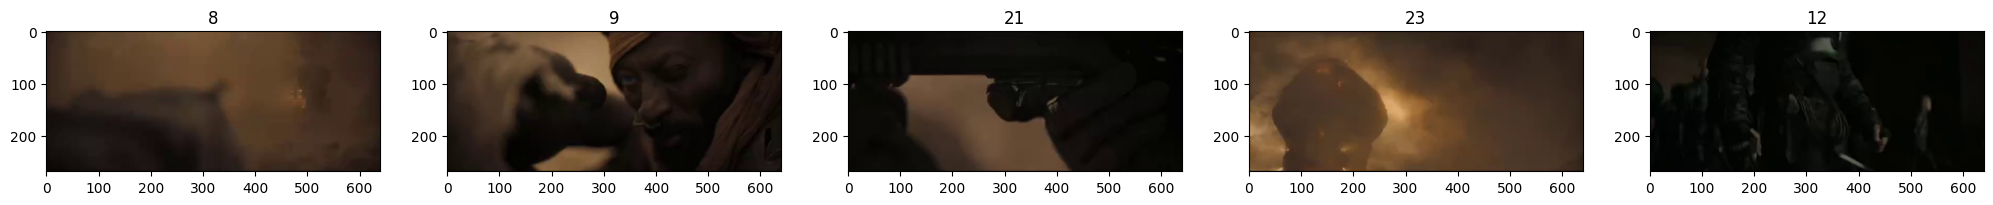

-- Scene 0 Max [0.31198186] --
Arrakis – Dune – Desert Planet.


64it [00:18,  3.38it/s]
22it [00:06,  3.47it/s]


** NEW CHAPTER **
Chapter 2


52it [00:15,  3.46it/s]
26it [00:07,  3.40it/s]
39it [00:11,  3.54it/s]


** NEW CHAPTER **
Chapter 3


32it [00:08,  3.71it/s]
24it [00:07,  3.38it/s]
35it [00:10,  3.39it/s]


** NEW CHAPTER **
Chapter 4


35it [00:10,  3.45it/s]
26it [00:07,  3.40it/s]
72it [00:20,  3.50it/s]


** NEW CHAPTER **
Chapter 5


13it [00:03,  3.27it/s]
13it [00:03,  3.33it/s]
26it [00:07,  3.49it/s]


** NEW CHAPTER **
Chapter 6


20it [03:43, 11.17s/it]
35it [06:16, 10.76s/it]


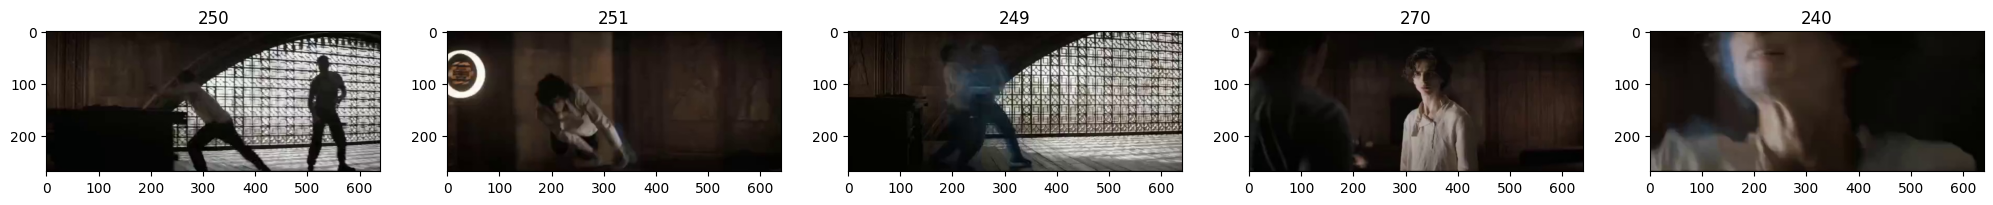

-- Scene 9 Max [0.3042729] --
‘But the supporting levies the Emperor demands from—’


29it [05:09, 10.69s/it]


** NEW CHAPTER **
Chapter 7


20it [00:05,  3.65it/s]
13it [00:03,  3.48it/s]
25it [00:07,  3.51it/s]
18it [00:05,  3.50it/s]
35it [00:10,  3.33it/s]
28it [00:08,  3.47it/s]


** NEW CHAPTER **
Chapter 8


14it [00:07,  1.90it/s]
30it [00:16,  1.87it/s]
53it [00:29,  1.81it/s]


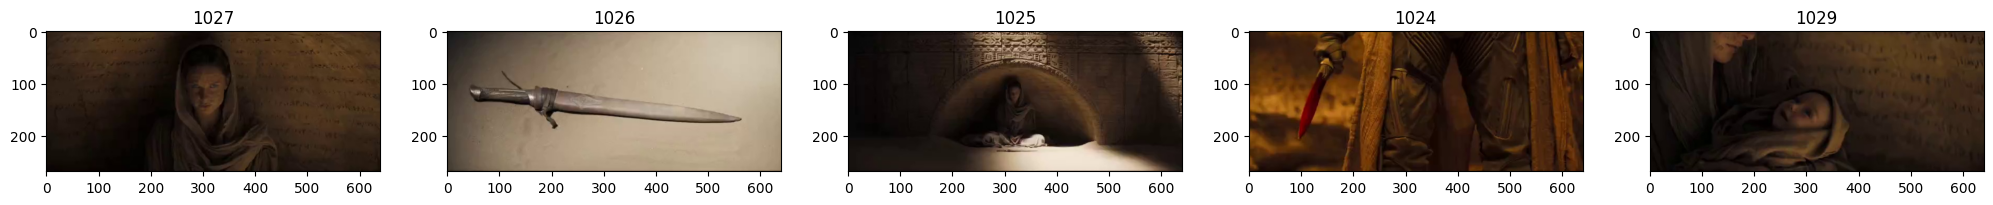

-- Scene 43 Max [0.30165878] --
I am the Duke’s secretary – so busy that each day I learn new things to fear … things even he doesn’t suspect I know.’ She compressed her lips, spoke thinly: ‘Sometimes I wonder how much my Bene Gesserit business training figured in his choice of me.


14it [00:08,  1.71it/s]


** NEW CHAPTER **
Chapter 9


8it [00:04,  1.78it/s]
10it [00:05,  1.77it/s]
11it [00:05,  1.93it/s]
7it [00:04,  1.74it/s]
12it [00:06,  1.74it/s]


** NEW CHAPTER **
Chapter 10


17it [00:04,  3.47it/s]
18it [00:04,  3.76it/s]
16it [00:04,  3.38it/s]
22it [00:06,  3.55it/s]
27it [00:07,  3.43it/s]
15it [00:04,  3.37it/s]


** NEW CHAPTER **
Chapter 11


4it [00:01,  3.39it/s]
1it [00:00,  3.42it/s]
2it [00:00,  3.38it/s]
2it [00:00,  3.36it/s]
11it [00:03,  3.32it/s]
9it [00:02,  3.32it/s]
37it [00:10,  3.55it/s]
1it [00:00,  3.29it/s]


** NEW CHAPTER **
Chapter 12


10it [00:05,  1.88it/s]
16it [00:08,  1.86it/s]
43it [00:24,  1.74it/s]
78it [00:43,  1.78it/s]


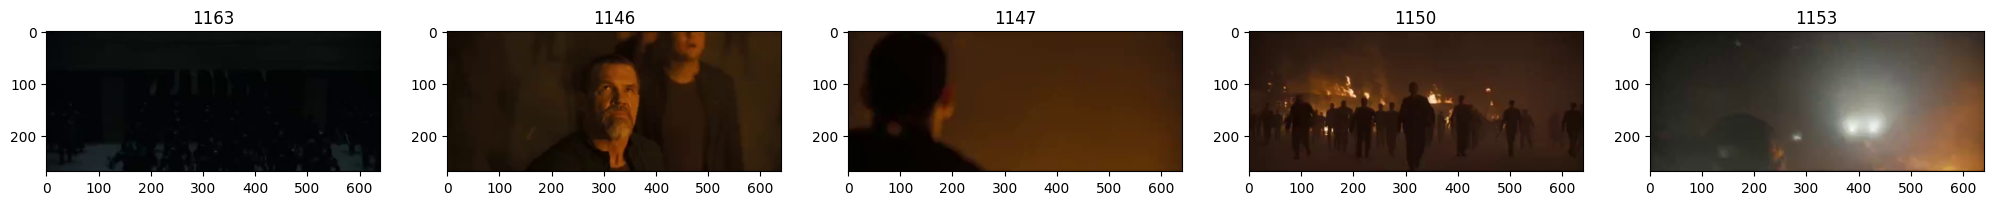

-- Scene 50 Max [0.30684352] --
A light tan robe completely enveloped the man except for a gap in the hood and black veil that exposed eyes of total blue – no white in them at all.


26it [00:14,  1.79it/s]
33it [00:18,  1.77it/s]


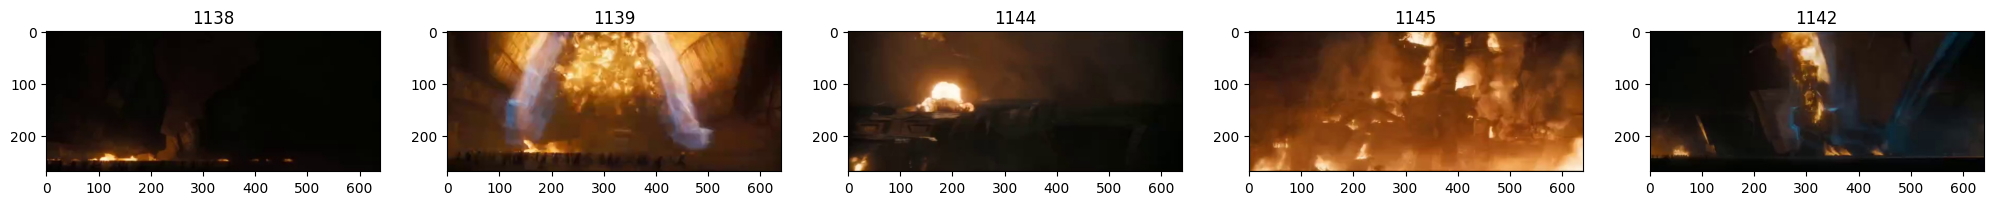

-- Scene 49 Max [0.30056843] --
A look of understanding passed between Leto and Hawat, They smiled.


17it [00:09,  1.76it/s]


** NEW CHAPTER **
Chapter 13


5it [00:01,  3.44it/s]
13it [00:03,  3.46it/s]
11it [00:03,  3.38it/s]
13it [00:03,  3.42it/s]
14it [00:03,  3.63it/s]
14it [00:04,  3.42it/s]


** NEW CHAPTER **
Chapter 14


6it [00:01,  3.05it/s]
11it [00:03,  3.33it/s]
11it [00:03,  3.37it/s]
10it [00:02,  3.41it/s]


** NEW CHAPTER **
Chapter 15


28it [00:07,  3.70it/s]
13it [00:03,  3.61it/s]
42it [00:12,  3.38it/s]
24it [00:06,  3.77it/s]
48it [00:13,  3.64it/s]
0it [00:00, ?it/s]
6it [00:01,  3.31it/s]
20it [00:05,  3.58it/s]
19it [00:05,  3.36it/s]
0it [00:00, ?it/s]
25it [00:07,  3.46it/s]
70it [00:19,  3.68it/s]
15it [00:04,  3.46it/s]
35it [00:09,  3.70it/s]


** NEW CHAPTER **
Chapter 16


42it [00:11,  3.53it/s]
16it [00:04,  3.45it/s]
53it [00:15,  3.42it/s]
49it [00:13,  3.67it/s]
34it [00:09,  3.49it/s]
24it [00:07,  3.43it/s]
19it [00:05,  3.39it/s]


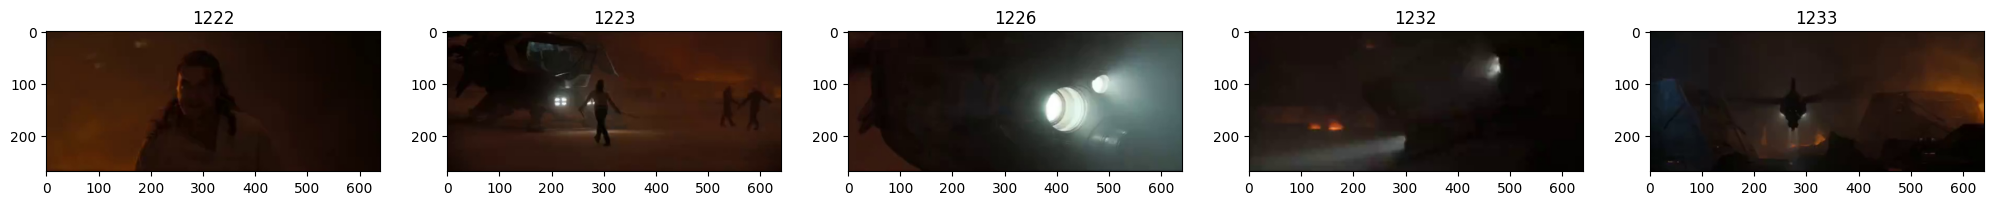

-- Scene 54 Max [0.3091066] --
‘To young Paul Atreides, still a lad by his looks, but a man by his actions.’


12it [00:03,  3.41it/s]
12it [00:03,  3.26it/s]
15it [00:04,  3.36it/s]


** NEW CHAPTER **
Chapter 17


63it [00:18,  3.40it/s]
11it [00:03,  3.63it/s]
25it [00:07,  3.39it/s]
34it [00:09,  3.45it/s]
60it [00:17,  3.44it/s]


** NEW CHAPTER **
Chapter 18


27it [00:08,  3.37it/s]
28it [00:08,  3.26it/s]


** NEW CHAPTER **
Chapter 19


21it [00:06,  3.47it/s]
31it [00:08,  3.54it/s]
24it [00:06,  3.72it/s]
30it [00:08,  3.43it/s]
49it [00:13,  3.57it/s]


** NEW CHAPTER **
Chapter 20


17it [00:04,  3.67it/s]
25it [00:07,  3.44it/s]


** NEW CHAPTER **
Chapter 21


46it [01:55,  2.52s/it]
64it [02:39,  2.49s/it]
15it [00:37,  2.52s/it]
15it [00:37,  2.49s/it]
42it [01:41,  2.41s/it]


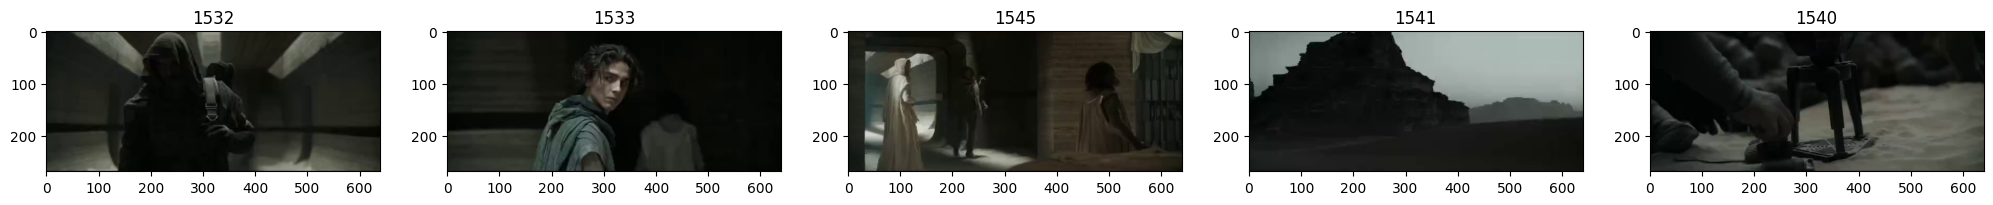

-- Scene 66 Max [0.33796287] --
The one with the lovely eyes, the one who looks so much like the young Paul Atreides.
** NEW CHAPTER **
Chapter 22


27it [00:08,  3.33it/s]
40it [00:11,  3.46it/s]
20it [00:05,  3.53it/s]
20it [00:05,  3.70it/s]
15it [00:04,  3.35it/s]
37it [00:10,  3.41it/s]
22it [00:05,  3.69it/s]


** NEW CHAPTER **
Chapter 23


18it [00:15,  1.17it/s]
43it [00:36,  1.19it/s]


** NEW CHAPTER **
Chapter 24


23it [00:06,  3.29it/s]
81it [00:22,  3.53it/s]
35it [00:10,  3.38it/s]
13it [00:03,  3.35it/s]
9it [00:02,  3.37it/s]


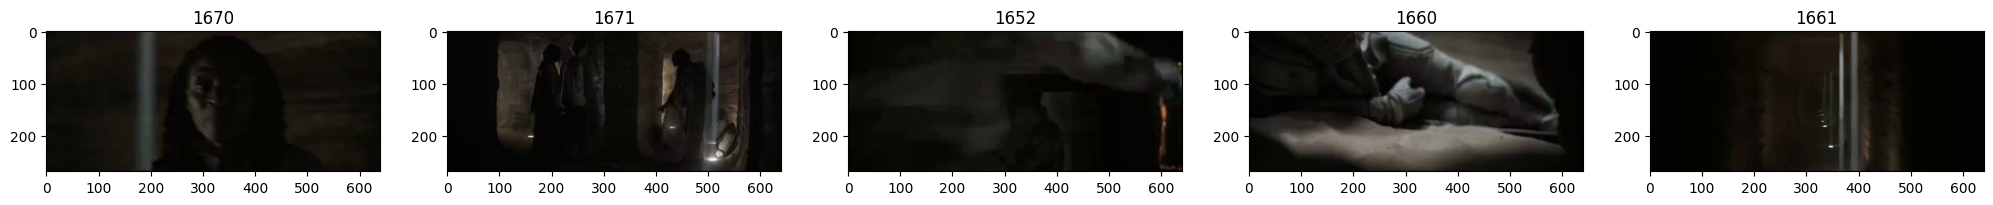

-- Scene 72 Max [0.30567098] --
The ’thopter circled once over them in a tight curve, came back for a dust-shrouded landing in front of the Fremen.


0it [00:00, ?it/s]
23it [00:06,  3.71it/s]


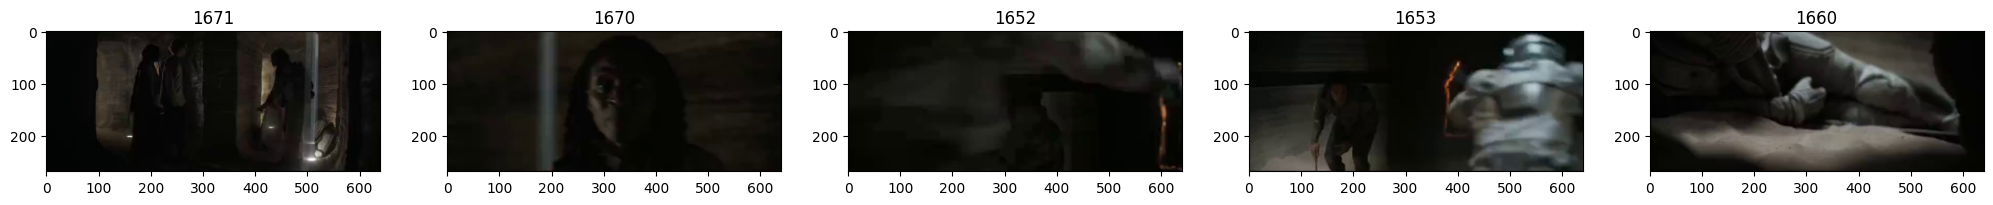

-- Scene 72 Max [0.3032108] --
Another ’thopter glided in over the cliff wall above Hawat.
** NEW CHAPTER **
Chapter 25


31it [00:08,  3.46it/s]
34it [00:09,  3.45it/s]
2it [00:00,  3.42it/s]
45it [00:12,  3.58it/s]
18it [00:05,  3.38it/s]
11it [00:03,  3.29it/s]
0it [00:00, ?it/s]
19it [00:05,  3.24it/s]
1it [00:00,  3.10it/s]
20it [00:05,  3.49it/s]
14it [00:04,  3.30it/s]


** NEW CHAPTER **
Chapter 26


14it [00:04,  3.26it/s]
4it [00:01,  3.29it/s]
7it [00:02,  3.29it/s]
9it [00:02,  4.37it/s]
0it [00:00, ?it/s]
6it [00:01,  3.39it/s]


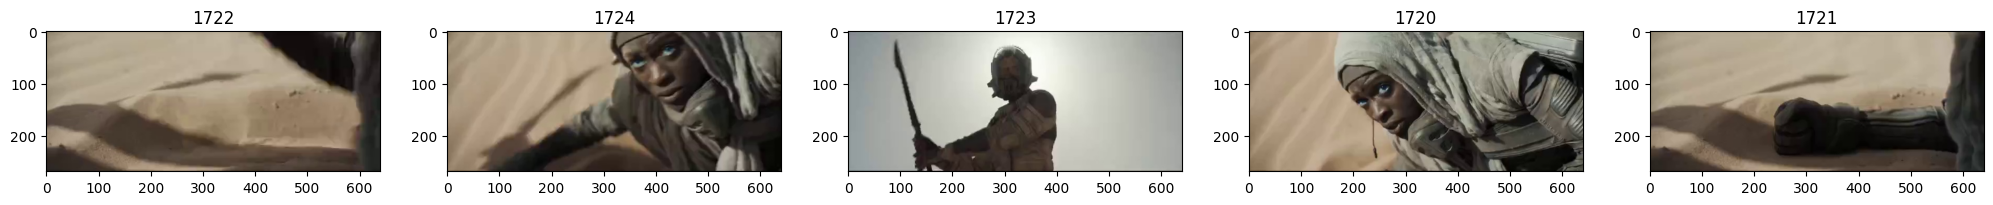

-- Scene 74 Max [0.3093975] --
In the desert where he couldn’t use his shield.


0it [00:00, ?it/s]
19it [00:04,  4.36it/s]
0it [00:00, ?it/s]
14it [00:03,  3.94it/s]
25it [00:06,  3.62it/s]
28it [00:07,  3.56it/s]
0it [00:00, ?it/s]
6it [00:01,  4.13it/s]
9it [00:02,  3.37it/s]
0it [00:00, ?it/s]
6it [00:01,  3.32it/s]
14it [00:03,  3.59it/s]


** NEW CHAPTER **
Chapter 27


19it [00:05,  3.30it/s]
31it [00:09,  3.41it/s]
47it [00:13,  3.41it/s]
14it [00:04,  3.36it/s]
26it [00:07,  3.39it/s]


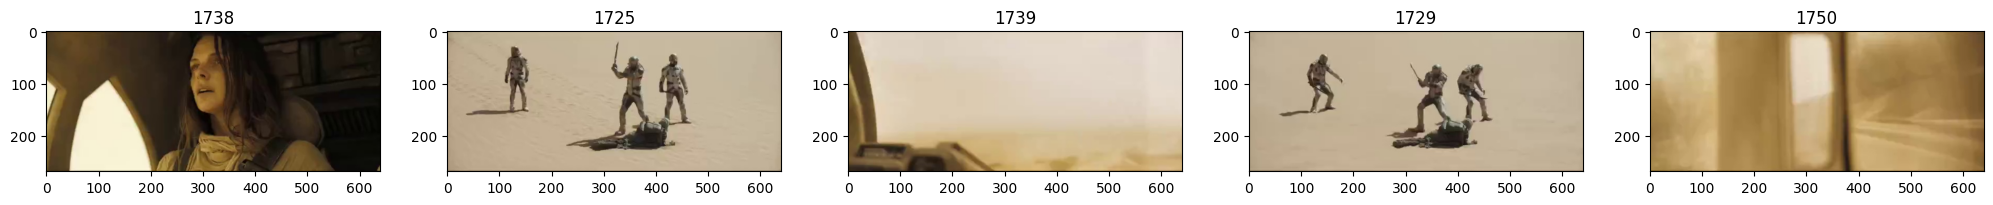

-- Scene 75 Max [0.3187028] --
There came the sound of sand sliding behind him.


78it [00:23,  3.39it/s]


** NEW CHAPTER **
Chapter 28


21it [00:23,  1.10s/it]
36it [00:40,  1.13s/it]
25it [00:28,  1.12s/it]
20it [00:23,  1.17s/it]


** NEW CHAPTER **
Chapter 29


17it [00:05,  3.37it/s]
15it [00:04,  3.18it/s]
1it [00:00, 953.47it/s]
3it [00:00,  3.26it/s]
1it [00:00,  3.18it/s]
3it [00:00,  3.20it/s]
1it [00:00,  3.15it/s]
8it [00:02,  3.78it/s]
0it [00:00, ?it/s]
1it [00:00,  3.37it/s]
47it [00:11,  3.93it/s]
36it [00:10,  3.35it/s]


** NEW CHAPTER **
Chapter 30


11it [00:03,  3.50it/s]
29it [00:08,  3.44it/s]


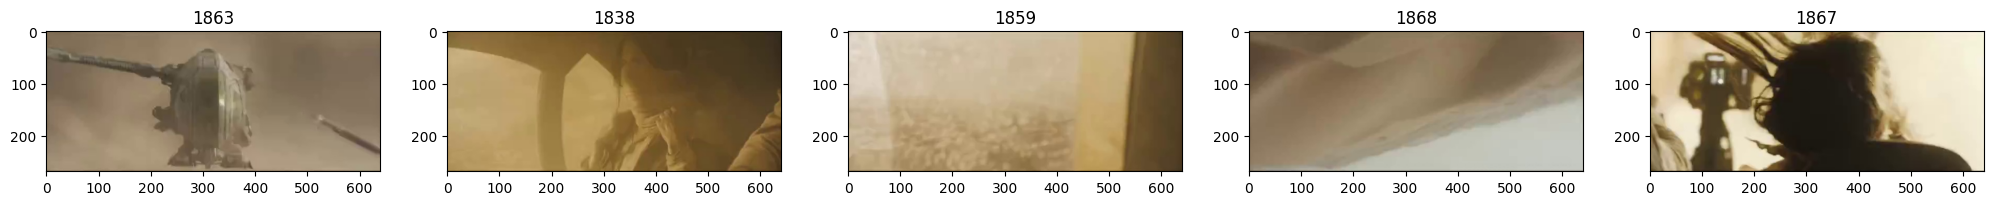

-- Scene 81 Max [0.30872157] --
The man crawled across a dunetop.


50it [00:14,  3.47it/s]


** NEW CHAPTER **
Chapter 31


23it [00:06,  3.54it/s]
27it [00:07,  3.49it/s]
16it [00:04,  3.49it/s]
30it [00:08,  3.52it/s]
43it [00:12,  3.53it/s]
29it [00:08,  3.41it/s]


** NEW CHAPTER **
Chapter 32


26it [00:07,  3.52it/s]
26it [00:07,  3.56it/s]
58it [00:16,  3.47it/s]


** NEW CHAPTER **
Chapter 33


38it [02:22,  3.74s/it]
26it [01:40,  3.87s/it]
62it [04:00,  3.88s/it]
17it [01:05,  3.87s/it]
36it [02:19,  3.87s/it]


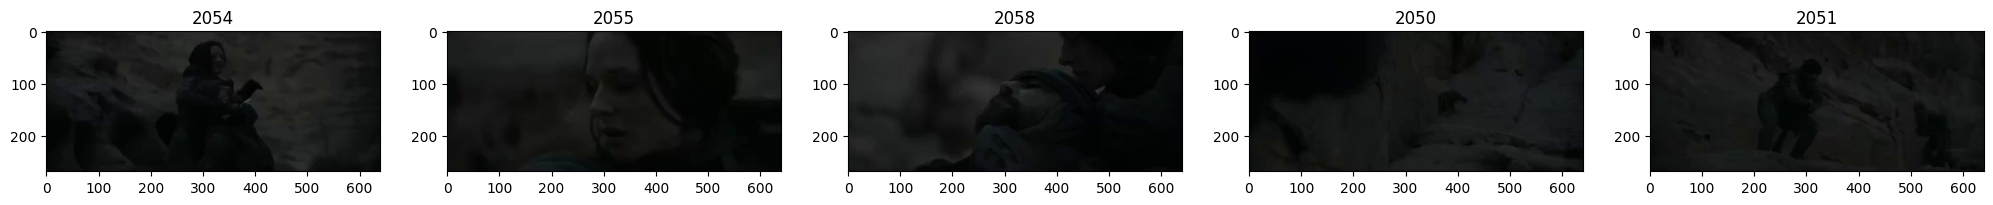

-- Scene 88 Max [0.31013432] --
It was the name Paul had told her, saying that the Fremen would accept them and call him thus.
** NEW CHAPTER **


In [45]:
chap_chunk_scene_alignment = {}

for chapterIdx in range(len(book.chapterContent)):
    
    print(f"Chapter {chapterIdx+1}")
    chap_chunk_scene_alignment[chapterIdx] = {}
    
    scenes_for_chapter = []
    
    for align in alignment:
        if int(align['chapter']) == chapterIdx:
            scenes_for_chapter.append(align['scene'])
            
    # Get chapter chunks
    chapterChunks = book.getAllChunks()[chapterIdx]
    
    for i, chunk in enumerate(chapterChunks):
        matched_scenes = matchChunkScenes(chunk, scenes_for_chapter)
        
        if len(matched_scenes) == 0:
            # print(chunk)
            matched_scene = matchChunkScenesCLIP(chunk, scenes_for_chapter)
            
        chap_chunk_scene_alignment[chapterIdx][chunk] = list(matched_scene) # Convert set to list
            
    print("** NEW CHAPTER **")
    
# break

In [46]:
savecache(chap_chunk_scene_alignment, 'chap_chunk_scene_alignment')

0

In [50]:
chap_chunk_scene_alignment = loadcache('chap_chunk_scene_alignment').item()
# chap_chunk_scene_alignment

# ----------------------------------- SONGS -----------------------------------

In [59]:
from scripts.voiceResult import Result

## Fetch a song

In [64]:
songInfo = np.load("processed/dune/songInfo.npy", allow_pickle=True)

In [65]:
def getCurSongs(songList, start, end):
    
    songs = []
    
    for song in songList:
#         print(song.time, s)
        if song.result['matches'] and song.time >= start and song.time <= end:
            songs.append(song.result)
            
    return songs

## Process and Extract a song

In [66]:
import pydub
from pydub import AudioSegment

Load music chunk - and return the chunk that the offset belongs to

In [67]:
def makeSnippet(name, offset):
    
    offset = int(offset)
    
    song = AudioSegment.from_mp3(os.path.join(f"data/dune/soundtrack/{name}"))
#     print(f"data/HP/soundtrack/{name}")
#     print(offset * 1000, min((offset + 120) * 1000, len(song)-1), len(song))
    
    song = song[offset * 1000: min((offset + 450) * 1000, len(song)-1)]
    new_song = song.fade_in(5000).fade_out(5000)
    
    return new_song

# Load all Music Chunks

In [68]:
SEGMENTED_AUDIO_PATH = "processed/dune/segmented_audio"


In [69]:
songs_list = sorted(os.listdir(SEGMENTED_AUDIO_PATH))
SONG_CHUNK_LIST = []
CHUNKS_PER_SONG = {}

for song_name in songs_list:
    
    SONG_INFO = []
    
    song_segmented_info = sio.loadmat(os.path.join(SEGMENTED_AUDIO_PATH, song_name))
    song_segmented_info = json.loads(song_segmented_info['song_segmented_json'][0])

    if type(song_segmented_info['segments']) is not list:
        song_segmented_info['segments'] = [song_segmented_info['segments']]
    
    start = 0
    for i, segment in enumerate(song_segmented_info['segments']):
        SONG_INFO.append({
            'name': song_name,
            'start': start,
            'end': segment,
            'mode': song_segmented_info['mode'][i],
            'rms': song_segmented_info['rms'][i]            
        })
    SONG_INFO.append({
        'name': song_name,
        'start': song_segmented_info['segments'][-1],
        'end': -1,
        'mode': song_segmented_info['mode'][-1],
        'rms': song_segmented_info['rms'][-1]            
    })
    
        
    CHUNKS_PER_SONG[song_name] = SONG_INFO
    
    for song_info in SONG_INFO:
        if 'Hedwig' not in song_info['name']:
            SONG_CHUNK_LIST.append(song_info)

# -------------------------------------- GENERATE ----------------------------------------

In [70]:
import random

## Get Book Emotion Files

In [71]:
emotion_sheets = sorted(os.listdir('processed/dune/book_emotions/'))

Get song list

In [72]:
songList = os.listdir("data/dune/soundtrack")

In [73]:
# Sometimes shazam names and the track names mismatch - choose the max overlap one
def getMatchingSongId(str1):
    return np.argmax(list(map(lambda x: pylcs.lcs(str1, ' '.join(x.split('-'))[1:]), songList)))

In [74]:
def prepare_song(songChunk, chunkText):
    
    word_count = len(chunkText.split())
    time_est = word_count // 300 * 60
    
    song = AudioSegment.from_mp3(os.path.join(f"data/dune/soundtrack/{songChunk['name'].replace('mat', 'mp3')}"))
    song = song[songChunk['start'] * 1000: songChunk['end'] * 1000 if songChunk['end'] != -1 else -1]
    
    song_length = int(song.duration_seconds)
    
#     print(song_length, time_est)
    
    if song_length < time_est:
        loop_count = int(time_est // song_length)
        
        for count in range(loop_count-1):
            song = song.append(song, crossfade=3000)
        
    song = song.fade_in(5000).fade_out(5000)
#     song -= 2
    
    return song

Go through chapter by chapter

In [75]:
def recycle_music(chunkText, prevSongChunk, emotion_labels):
    
    chunkEmotions = list(filter(lambda x: x not in ['neutral', 'ambiguous'], emotion_labels))
    chunkEmotions = dict(Counter(chunkEmotions))

    if 'positive' not in chunkEmotions:
        chunkEmotions['positive'] = 0
    if 'negative' not in chunkEmotions:
        chunkEmotions['negative'] = 0
    
    candidate_list = None

    if chunkEmotions['negative'] > chunkEmotions['positive']:
        candidate_list = list(filter(lambda x: x['mode'] < 0, SONG_CHUNK_LIST))
    elif chunkEmotions['negative'] <= chunkEmotions['positive']:
        candidate_list = list(filter(lambda x: x['mode'] >= 0, SONG_CHUNK_LIST))    
    
#     if chunkEmotions['negative'] > chunkEmotions['positive']:
#         candidate_list = list(filter(lambda x: x['mode'] < 0 and x['rms'] <= 0.03, SONG_CHUNK_LIST))
#     elif chunkEmotions['negative'] <= chunkEmotions['positive']:
#         candidate_list = list(filter(lambda x: x['mode'] >= 0  and x['rms'] <= 0.03, SONG_CHUNK_LIST))
    
    random_chunk = random.choice(candidate_list)
    if random_chunk == prevSongChunk:
        random_chunk = random.choice(candidate_list)
        
    return random_chunk

In [76]:
def get_chunk_music(chunkText, chunkScene, prevSongChunk, emotion_labels):
    
    chunkEmotions = list(filter(lambda x: x not in ['neutral', 'ambiguous'], emotion_labels))
    chunkEmotions = dict(Counter(chunkEmotions))

    if 'positive' not in chunkEmotions:
        chunkEmotions['positive'] = 0
    if 'negative' not in chunkEmotions:
        chunkEmotions['negative'] = 0
    
    start, end, num, start_t, end_t = scene_break_times[chunkScene]
    
    scene_songs = getCurSongs(songInfo, start_t, end_t)
    song_names = [scene_song['track']['title'] for scene_song in scene_songs]
    
    song_counter = dict(Counter(song_names))
    song_sorted = sorted(song_counter.keys(), key=lambda x: song_counter[x], reverse=True)
    
    if len(song_sorted) == 0:
        return None
    
    selected_song = song_sorted[0]

    songId = getMatchingSongId(selected_song)
    song = songList[songId]
    
    song_chunks = CHUNKS_PER_SONG[song.replace("mp3", "mat")]

    chosen_song_chunk = None
    
    for song_chunk in song_chunks:
        if song_chunk == prevSongChunk:
            continue
        
        if chunkEmotions['negative'] > chunkEmotions['positive'] and song_chunk['mode'] < 0:
            chosen_song_chunk = song_chunk
        elif chunkEmotions['negative'] <= chunkEmotions['positive'] and song_chunk['mode'] >= 0:
            chosen_song_chunk = song_chunk
            
    if chosen_song_chunk is None:
        song_chunks = sorted(song_chunks, key=lambda x: x['rms'])
        chosen_song_chunk = song_chunks[0] if song_chunks[0] != prevSongChunk else song_chunks[1]
        
    return chosen_song_chunk

In [85]:
def getChunkEmotions(emotion_file, chunkText):
    
    emotions = []
    
    chunkTextLines = chunkText.splitlines()
    
    for chunkTextLine in chunkTextLines:
        
        chunkTextLine = chunkTextLine.strip()
        
        if len(chunkTextLine) == 0:
            continue
        
        for para_idx in range(len(emotion_file)):
            
            para_text = emotion_file.iloc[para_idx]['paragraph']
            if chunkTextLine in para_text:
                
                emotion_str = emotion_file.iloc[para_idx]['ekman'].replace("\'", "\"")
                
                emotion = json.loads(emotion_str)
                
                try:
                    emotions.append(emotion['labels'][0])
                except:
                    continue
                
    return emotions

In [86]:
OUT_BASEDIR = "generated"
chunk_counts = []
per_chunk_counts = []

for chapterIdx in chap_chunk_scene_alignment.keys():
    
    print(f"Chapter {chapterIdx}")
    chapter = chap_chunk_scene_alignment[chapterIdx]

    emotion_file = pd.read_csv(os.path.join('processed/dune/book_emotions', emotion_sheets[chapterIdx]))
    
    prevSong = None
        
    avail = 0
    for chunkIdx, chunk in enumerate(chapter.keys()):
                        
        chunkText = chunk
        chunkScenes = chapter[chunk]

        chunkEmotions = getChunkEmotions(emotion_file, chunkText)
        
        if len(chunkScenes) == 0:
            song = recycle_music(chunkText, prevSong, chunkEmotions)
        else:
            chunkScene = chunkScenes[0]
            song = get_chunk_music(chunkText, chunkScene, prevSong, chunkEmotions)
            
            if song is None:
                song = recycle_music(chunkText, prevSong, chunkEmotions)
            else:
                avail += 1
                
        prevSong = song
        print('-', chunkIdx, song['name'])
        
    per_chunk_counts.append(avail)
    chunk_counts.append(len(chapter.keys()))

Chapter 0
- 0 Hans Zimmer - The Fall .mat
- 1 Hans Zimmer - Dream of Arrakis .mat
- 2 Hans Zimmer - Ripples in the Sand.mat
- 3 Hans Zimmer - Premonition .mat
Chapter 1
- 0 Hans Zimmer - Herald of the Change .mat
- 1 Hans Zimmer - Dream of Arrakis .mat
- 2 Hans Zimmer - Stillsuits .mat
Chapter 2
- 0 Hans Zimmer - Dream of Arrakis .mat
- 1 Hans Zimmer - Night on Arrakis .mat
- 2 Hans Zimmer - Ripples in the Sand.mat
Chapter 3
- 0 Hans Zimmer - Gom Jabbar .mat
- 1 Hans Zimmer - Herald of the Change .mat
- 2 Hans Zimmer - Dream of Arrakis .mat
Chapter 4
- 0 Hans Zimmer - Ripples in the Sand.mat
- 1 Hans Zimmer - Stillsuits .mat
- 2 Hans Zimmer - The Fall .mat
Chapter 5
- 0 Hans Zimmer - Sandstorm .mat
- 1 Hans Zimmer - Stillsuits .mat
- 2 Hans Zimmer - Ripples in the Sand.mat
Chapter 6
- 0 Hans Zimmer - Gom Jabbar .mat
- 1 Hans Zimmer - Dream of Arrakis .mat
- 2 Hans Zimmer - Ripples in the Sand.mat
- 3 Hans Zimmer - Gom Jabbar .mat
- 4 Hans Zimmer - The Fall .mat
- 5 Hans Zimmer - Sandst